# Frozen Lake: Hyperparameters

In reinforcement learning, an agent is acting in an environment, and learning by trial-and-error to optimize its performance in order to gain maximal cumulative reward. The model of the environment can be formalized by a Markov Decision Process (MDP), from which the optimal policy can be derived applying dynamic programming algorithms. This is called planning. If the MDP is not known, then the agent has to find it out by interacting with the environment. These kind of problems are studied in real reinforcement learning. 

Different algorithms exist to solve reinforcement learning problems, all of them having their own strenghts and weaknesses. Therefore the answer to the question which algorithm is the most efficient and effective, depends on the learning problem. But the performance of each individual algorithm can also be optimised by finetuning the hyperparameters that also determine the convergence of the iterative process applied by the algorithm.

This notebook discusses the hyperparameters used by the learning strategies Q-Learning, Monte Carlo, N-Step Q-Learning, and Value Iteration. It illustrates how to investigate the impact of these hyperparameters on the rate of convergence. All examples use the Frozen Lake environment as test case. 

## Import module ReinforcementLearning 

The reinforcement learning strategies Q-Learning, N-Step Q-Learning, Monte Carlo, and Value Iteration are implemented in the "ReinforcementLearning" module, as is the "FrozenLake" wrapper class to create a Frozen Lake environment. Importing this module also imports packages "numpy" as "np" and "matplotlib.pyplot" as "plt". Matplotlib is set to the interactive "notebook" mode:

In [1]:
from ReinforcementLearning import *
%matplotlib notebook

The four learning strategies are implemented in separate classes, which are subclasses of the abstract class "LearningStrategy". The latter has a method "set_monitor" which enables to save intermediate results that can be analyzed after the learningprocess is terminated. These intermediate results are stored in attribute "monitor" after each episode the agent finishes. This is very useful to study the rate of convergence and how it is influenced by the choice of the hyperparameter values.

## Number of Episodes

In all learning strategies the agent runs a large number of episodes. It is clear that a sufficient number of episodes must be run by the agent to let him take enough samples from the environment. But what is a sufficent number? This can be checked by saving the intermediate V- or Q-values, plot these values as a function of the episode number, and check how fast they stabilize:

In [2]:
env = FrozenLake.make(is_slippery=True)
policy = UniformRandomPolicy(env)

seed = 2020
policy.seed(seed)
env.seed(seed)

strategy = QLearning(num_of_episodes=1000,
                     policy=policy, 
                     learning_rate=0.2, 
                     gamma=0.9,
                     decay_rate=0.005)

agent = Agent(env, strategy)

To save the intermediate Q-values after each episode, the "set_monitor" method is called and argument "Qsa" is set to "True":

In [3]:
strategy.set_monitor(Qsa=True)

Now the agent can learn while the Q-values are monitored:

<IPython.core.display.Javascript object>


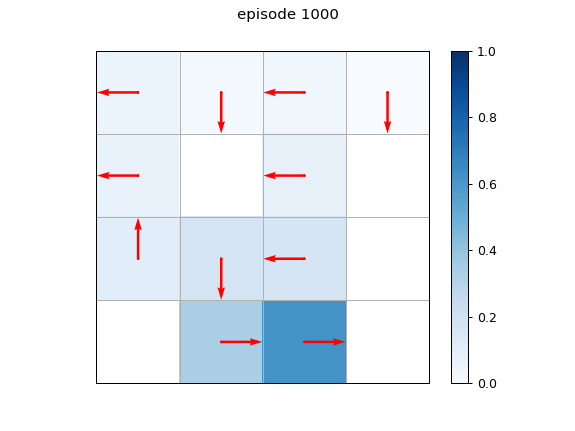

In [4]:
agent.learn(plot_frequency=100)

Plotting the mean of the intermediate Q-values as a function of the episode: 

<IPython.core.display.Javascript object>


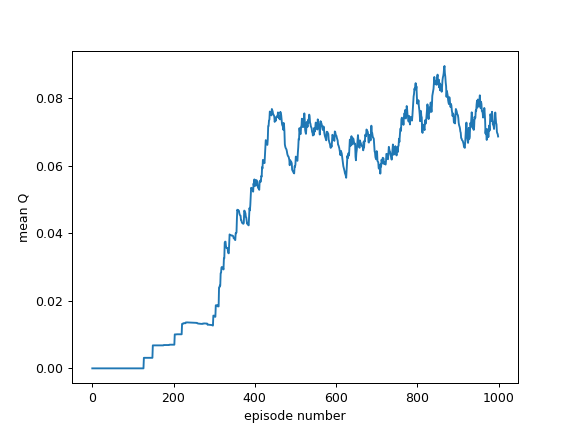

In [5]:
meanQ = []
for Q in strategy.monitor["Qsa"]:
    meanQ.append(np.mean(Q))

fig = plt.figure()
ax = plt.axes()
ax.plot(meanQ)
ax.set_xlabel("episode number")
ax.set_ylabel("mean Q")
fig.show()
fig.canvas.draw()

The Q-values are not really stabilizing after 1000 episodes and therefore the given number of epsidodes is doubled:

In [6]:
policy = UniformRandomPolicy(env)

seed = 2020
policy.seed(seed)
env.seed(seed)

strategy = QLearning(num_of_episodes=2000,
                     policy=policy, 
                     learning_rate=0.2, 
                     gamma=0.9,
                     decay_rate=0.005)

agent = Agent(env, strategy)

Instead of saving all Q-values and calculating the mean afterwards, the mean function can be passed to "set_monitor". The given function is evaluated on the intermediate Q-values:

<IPython.core.display.Javascript object>


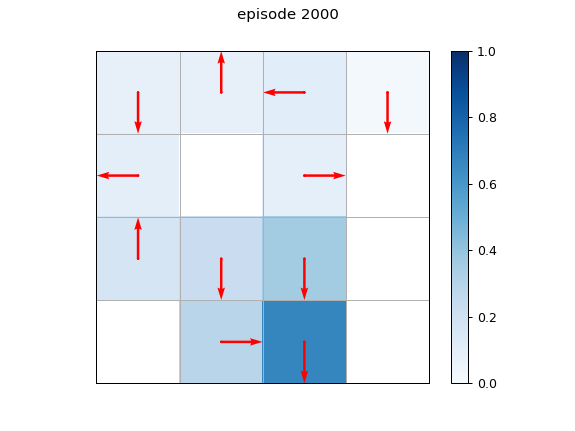

In [7]:
strategy.set_monitor(Qsa=np.mean)
agent.learn(plot_frequency=200)

Because the mean function was given, attribute "monitor" now holds the mean Q-value for each episode:

<IPython.core.display.Javascript object>


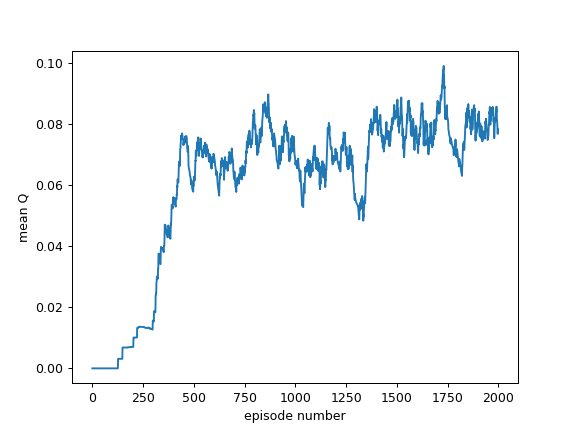

In [8]:
fig = plt.figure()
ax = plt.axes()
ax.plot(strategy.monitor["Qsa"])
ax.set_xlabel("episode number")
ax.set_ylabel("mean Q")
fig.show()
fig.canvas.draw()

The graph still shows fluctuations, which hopefully can be reduced by modifying other hyperparameters.

It is also possible to save the intermediate V-values or the intermediate policy matrix by respectively setting input arguments "Vs" or "policy" to "True" when calling method "set_monitor". If a function is set to these arguments, the function is applied to the intermediate V-values or policy matrix. The results are saved in attribute "monitor" of the "LearningStrategy" object. This attribute holds a dictionary with keys "Vs", "Qsa", and "policy". If "True" or a function was assigned to the corresponding arguments of the "set_monitor" function, then these keys will contain a list of the respective intermediate results. 

## Epsilon-Greedy Policy Improvement

Improving the policy greedily means that the new policy always selects the action with the largest action-value Q. This improved policy is deterministic. The epsilon-greedy policy improvement creates a new stochastich policy where the action with the largest Q-value is selected with a probability equal to $ 1 - \epsilon + \epsilon/n _a $ with $ n _a $ the number of actions. The other actions are selected with a probability of $ \epsilon/n _a $. The parameter $ \epsilon $ is determined by a given minimum and maximum value, by the episode number and by the given decay rate:

In [9]:
def epsilon(decay_rate, episode_number, epsilon_min=0.01, epsilon_max=1.0):
    eps = epsilon_min + (epsilon_max - epsilon_min) * np.exp(-decay_rate * episode_number)
    return eps

Because each of the four learning algorithms apply the epsilon-greedy policy improvement, they all have the minimum and maximum epsilon value and the decay rate as hyperparameters. As is the case for the above function, the minimum and maximum epsilon are also optional input arguments in these algorithms, having the same default values. The decay rate is a required input argument. All parameters are positive. As a consequence, the exponential function has a negative power, and epsilon is getting smaller the more episodes the agent has run until it becomes equal to the minimum value. When this value is very close to zero, the policy improvement can be considered greedily. How fast epsilon decreases, depends on the decay rate. The following graph illustrates this by plotting epsilon as a function of the episode number for different decay rates:

<IPython.core.display.Javascript object>


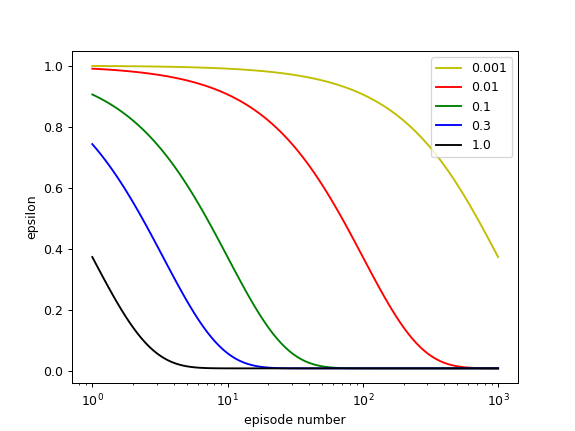

In [10]:
decay_rates = [0.001, 0.01, 0.1, 0.3, 1.0]
n = np.logspace(0, 3, 100)  # episode numbers

colors  = ['y', 'r', 'g', 'b', 'k']
labels  = [str(rate) for rate in decay_rates]
fig = plt.figure()
ax = plt.axes()
for rate, color in zip(decay_rates, colors):
    ax.semilogx(n, epsilon(rate, n), color)
ax.set_xlabel("episode number")
ax.set_ylabel("epsilon")
ax.legend(labels)
fig.show()
fig.canvas.draw()

The semilogarithmic plot shows that the larger the decay rate the faster epsilon reaches its minimum value. That means that the policy improvement becomes more greedily more quickly, leaving less room for the agent to explore the environment. When the decay rate is 1.0, the improvement even becomes greedily after only a few episodes.

To illustrate the impact of the decay rate on the policy improvement, a deterministic Frozen Lake environment is created in which an agent applies the Monte Carlo method to find the optimal policy:

In [11]:
env = FrozenLake.make(is_slippery=False)

A function is defined that let another agent follow the intermediate policy calculated by the "MonteCarlo" object to see if the policy is optimal, which is the case if the agent reaches the final goal and gets a reward equal to 1. 

In [12]:
def is_optimal(strategy):
    # strategy is a LearningStrategy object
    agent = Agent(env)
    episode = agent.walk(strategy.policy)
    return episode.percepts[episode.n-1, 2] == 1  # reward is 1

The agent will start following a uniform random policy that is passed to the created "MonteCarlo" object. The minimum value for epsilon is set to 1E-5, and the decay rate to 0.01. Thousand episodes will be run by the agent:

In [13]:
policy = UniformRandomPolicy(env)

seed = 0
policy.seed(seed)

strategy = MonteCarlo(num_of_episodes=1000,
                      policy=policy, 
                      learning_rate=1.0, 
                      gamma=0.9,
                      decay_rate=0.01,
                      epsilon_min=1e-5)

agent = Agent(env, strategy)

Again, the "set_monitor" method is used, but this time the check function is set, which can be any function that accepts a "LearningStrategy" object as input. In this case, the "is_optimal" function is passed via the "check" argument:

In [14]:
strategy.set_monitor(check=is_optimal)

Finally, the agent's "learn" method is called:

<IPython.core.display.Javascript object>


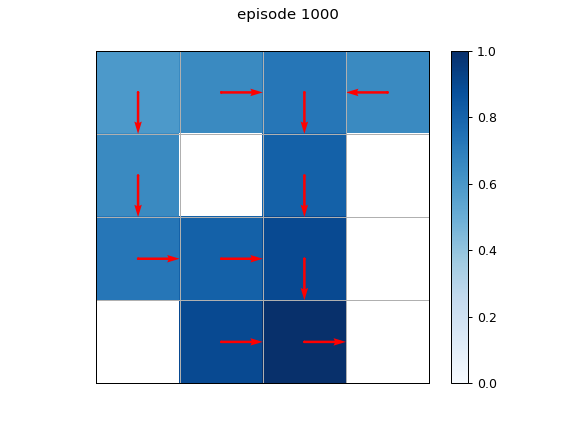

In [15]:
agent.learn(plot_frequency=50)

The return value of the given check function is saved in key "check" of the dictionary assigned to attribute "monitor" of the "LearningStrategy" object. In this case, it holds a list of booleans indicating whether an optimal policy was calculated or not. Plotting this list shows that 500 episodes would have sufficed:

<IPython.core.display.Javascript object>


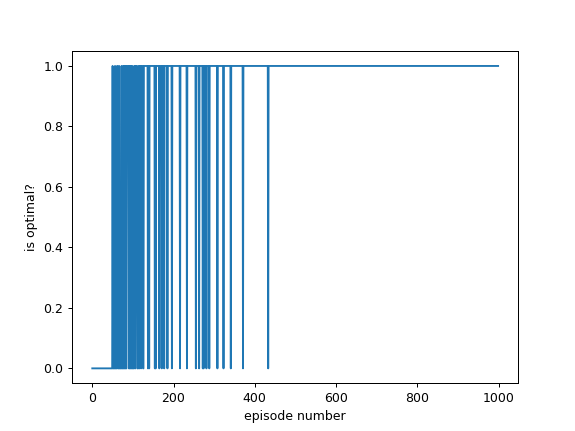

In [16]:
fig = plt.figure()
ax = plt.axes()
ax.plot(strategy.monitor["check"])
ax.set_xlabel("episode number")
ax.set_ylabel("is optimal?")
fig.show()
fig.canvas.draw()

Repeating the simulation using a decay rate of 0.1:

<IPython.core.display.Javascript object>


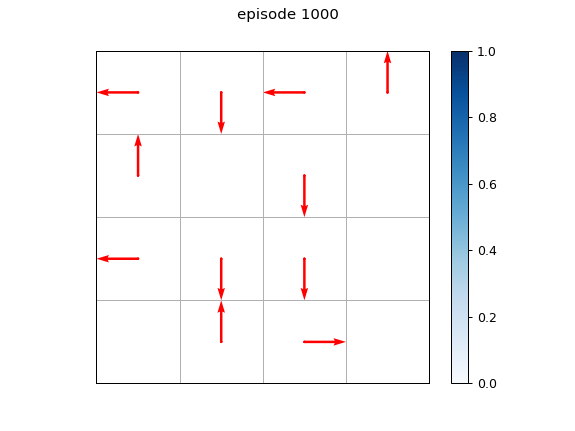

In [17]:
policy = UniformRandomPolicy(env)

seed = 0
policy.seed(seed)

strategy = MonteCarlo(num_of_episodes=1000,
                      policy=policy, 
                      learning_rate=1.0, 
                      gamma=0.9,
                      decay_rate=0.1,
                      epsilon_min=1e-5)
strategy.set_monitor(check=is_optimal)

agent = Agent(env, strategy)
agent.learn(plot_frequency=50)

Apparently, the policy improvement is too greedy in this case, because no optimal policy was found, which is clearly seen on the plot:

<IPython.core.display.Javascript object>


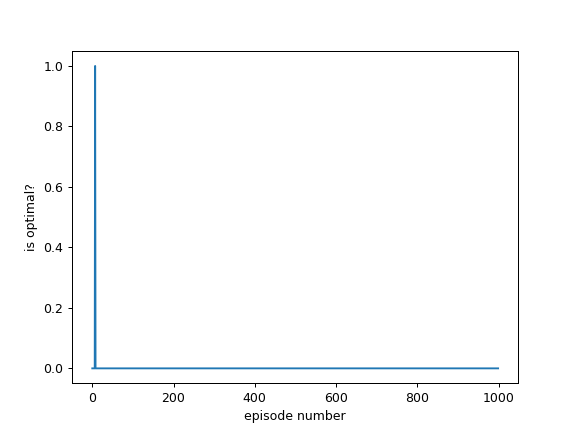

In [18]:
fig = plt.figure()
ax = plt.axes()
ax.plot(strategy.monitor["check"])
ax.set_xlabel("episode number")
ax.set_ylabel("is optimal?")
fig.show()
fig.canvas.draw()

## Learning Rate 

The learning rate, usely denoted by the Greek letter alpha, is a hyperparameter in the Q-Learning, the Monte Carlo, and the N-Step Q-Learning method. These algorithms update the action-value function $ Q $ as follows:

$$ Q _k(s,a) = Q _{k-1}(s,a) + \alpha \left[ r + \gamma \max _{a'}\left( Q _{k-1}(s',a') \right) - Q _{k-1}(s,a) \right] $$

with $ s $ the current state, $ a $ the selected action, $ r $ the received reward, $ s' $ the next state, $ a' $ an action that can be taken in state $ s' $, $ \gamma $ the discount factor, and $ k $ the iteration number. Learning rate $ \alpha $ is a number between 0 and 1, where $ \alpha = 0 $ doens't update the Q-value and makes the agent learn nothing, and $ \alpha = 1 $ fully replaces it by the most recent information and makes the agent ignore prior knowledge. 

In a deterministic environment, the learning rate can be set to 1, in a stochastic environment, the value of this hyperparameter has an important impact on the convergence, as will be illustrated in the following example in which the Monte Carlo method is applied to find the optimal policy of the stochastic Frozen Lake environment:

In [19]:
env = FrozenLake.make(is_slippery=True)

seed = 1

learning_rates = [0.9, 0.5, 0.1, 0.01]

Qmean = []

for alpha in learning_rates:
    
    print("learning rate " + str(alpha))
    
    policy = UniformRandomPolicy(env)

    policy.seed(seed)
    env.seed(seed)

    strategy = MonteCarlo(num_of_episodes=1500,
                          policy=policy, 
                          learning_rate=alpha, 
                          gamma=0.9,
                          decay_rate=0.005)
    strategy.set_monitor(Qsa=np.mean)
    
    agent = Agent(env, strategy)
    agent.learn()
    
    Qmean.append(np.array(strategy.monitor["Qsa"]))

learning rate 0.9
learning rate 0.5
learning rate 0.1
learning rate 0.01


The problem is solved 4 times using 4 different learning rates: 0.9, 0.5, 0.1, and 0.01. For each simulation, the mean Q-value is saved after each episode. These mean Q-values are plotted against the episode number for the 4 cases:  

<IPython.core.display.Javascript object>


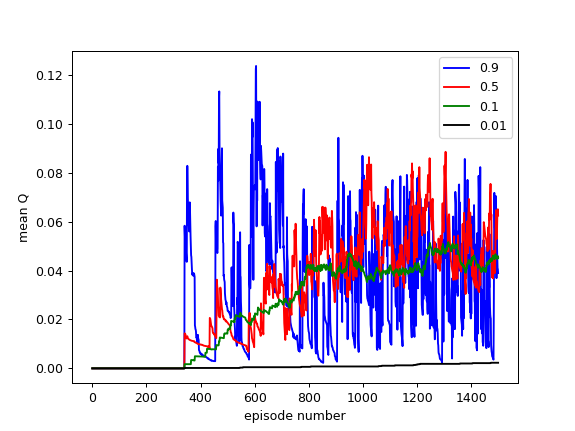

In [20]:
colors  = ['b', 'r', 'g', 'k']
labels  = [str(alpha) for alpha in learning_rates]
fig = plt.figure()
ax = plt.axes()
for q, color in zip(Qmean, colors):
    ax.plot(q, color)
ax.set_xlabel("episode number")
ax.set_ylabel("mean Q")
ax.legend(labels)
fig.show()
fig.canvas.draw()

The curves of the two largest learning rate values have a lot of fluctuations, whereas the curve of the lowest learning rate shows that the learning is much too slow. The learning rate of 0.1 seems to be a good choice for this example. 

## Step Size N 

A similar experiment is done to check the impact of the step size N when applying N-Step Q-Learning:

In [21]:
env = FrozenLake.make(is_slippery=True)

seed = 10

Nsteps = [1, 2, 5, 10]

Qmax = []

for N in Nsteps:
    
    print("step size " + str(N))
    
    policy = UniformRandomPolicy(env)

    policy.seed(seed)
    env.seed(seed)

    strategy = NStepQLearning(num_of_episodes=1000,
                              policy=policy, 
                              learning_rate=0.1,
                              Nstep=N,
                              gamma=0.9,
                              decay_rate=0.005)
    strategy.set_monitor(Qsa=np.max)
    
    agent = Agent(env, strategy)
    agent.learn()
    
    Qmax.append(np.array(strategy.monitor["Qsa"]))

step size 1
step size 2
step size 5
step size 10


Four step sizes are considerd. The first step size of 1 corresponds to the Q-Learning algorithm. The other step sizes are 2, 5 and 10. This time the maximum Q-value is saved after each episode. These maximum Q-values are plotted against the episode number for the four simulations: 

<IPython.core.display.Javascript object>


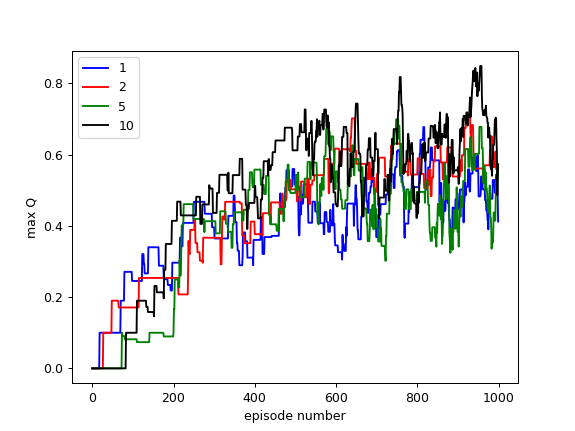

In [22]:
colors  = ['b', 'r', 'g', 'k']
labels  = [str(N) for N in Nsteps]
fig = plt.figure()
ax = plt.axes()
for q, color in zip(Qmax, colors):
    ax.plot(q, color)
ax.set_xlabel("episode number")
ax.set_ylabel("max Q")
ax.legend(labels)
fig.show()
fig.canvas.draw()

The graph shows that the step size has no important impact on the convergence rate. But it is clear that augmenting the step size reduces the computation time significantly.

## Value Iteration Precision 

The Value Iteration learning algorithm applies dynamic programming to update the state-value function V after each step. This is an iterative procedure that is stopped when a given maximum number of iterations or a given precision is reached. Defining a precision that gives accurate results avoids performing too less or too much iterations. Therefore, a similar experiment is done as in the previous two examples to check the impact of the precision on the convergence rate and the accuracy of the calculated V-values:  

In [23]:
env = FrozenLake.make(is_slippery=True)

seed = 100

precision = [1e-3, 1e-5, 1e-7]

Vmax = []
niter = []

for p in precision:
    
    print("precision " + str(p))
    
    policy = UniformRandomPolicy(env)

    policy.seed(seed)
    env.seed(seed)

    strategy = ValueIteration(num_of_episodes=500,
                              policy=policy,
                              precision=p,
                              maxiter=np.Inf,
                              gamma=0.9,
                              decay_rate=0.005)
    strategy.set_monitor(Vs=np.max, check=lambda strategy: strategy._iter)
    
    agent = Agent(env, strategy)
    agent.learn()
    
    Vmax.append(np.array(strategy.monitor["Vs"]))
    niter.append(np.array(strategy.monitor["check"]))

precision 0.001
precision 1e-05
precision 1e-07


Three cases are simulated using the following precision values: 1e-3, 1e-5, and 1e-7. The maximum number of iterations is set to infinity to ensure the iterative process only stops when the given precision is obtained. The maximum of the intermediate V-values after each episode is saved, as is the number of iterations performed in the last step of each episode. This is done by defining a check function that returns attribute "_iter" of the "ValueIteration" object, which holds the iteration number. The maximum number of iterations in the three cases is:

In [24]:
for p, n in zip(precision, niter):
    print("precision = " + str(p) + ": max number of iterations is " + str(np.max(n)))

precision = 0.001: max number of iterations is 15
precision = 1e-05: max number of iterations is 32
precision = 1e-07: max number of iterations is 49


As expected, the higher the precision, the more iterations. Plotting the maximum V-values:

<IPython.core.display.Javascript object>


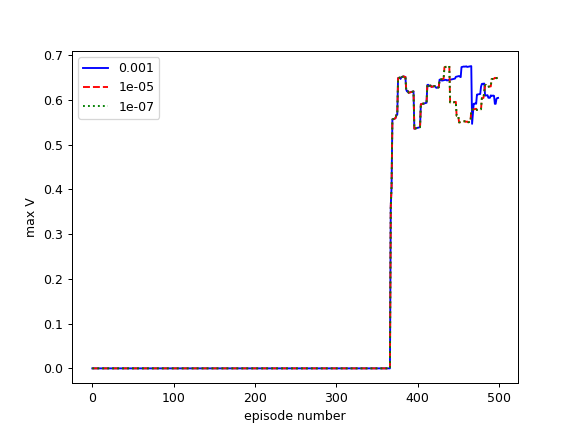

In [25]:
colors  = ['b', 'r', 'g']
linestyles = ["-", "--", ":"]
labels  = [str(p) for p in precision]
fig = plt.figure()
ax = plt.axes()
for v, color, ls in zip(Vmax, colors, linestyles):
    ax.plot(v, color, ls=ls)
ax.set_xlabel("episode number")
ax.set_ylabel("max V")
ax.legend(labels)
fig.show()
fig.canvas.draw()

The graph shows that a precision of 1e-3 is too low to obtain accurate results, whereas a precision of 1e-5 is sufficiently high as it produces the same results as the simulation using a precision of 1e-7.

## Value Iteration Planning versus Learning

The Value Iteration planning algorithm doesn't use a policy to solve the MDP, whereas the Value Iteration learning algorithm does. As a consequence, the state-value function calculated using the latter is always smaller than the state-value function calculated using the first. However, because the policy in the learning strategy is improved every step and becoming more and more greedy, the V-values calculated using the learning algorithm should converge to the V-values calculated using the planning algorithm.

This can be verified easily by defining a check function that calculates the state-value function V of the empirical MDP after each episode and returns the maximum value of V: 

In [26]:
def value_iteration(strategy):
    _, v, _ = strategy.mdp.value_iteration(outer=1000)
    return np.max(v)

This function is set to input argument "check" of the "set_monitor" method:

In [27]:


env = FrozenLake.make(is_slippery=True)

seed = 100

policy = UniformRandomPolicy(env)

policy.seed(seed)
env.seed(seed)

strategy = ValueIteration(num_of_episodes=1000,
                          policy=policy,
                          precision=1e-5,
                          maxiter=np.Inf,
                          gamma=0.9,
                          decay_rate=0.005)
strategy.set_monitor(Vs=np.max, check=value_iteration)
    
agent = Agent(env, strategy)
agent.learn()

Plotting the result shows the expected result: both curves are similar and are getting closer to each other.

<IPython.core.display.Javascript object>


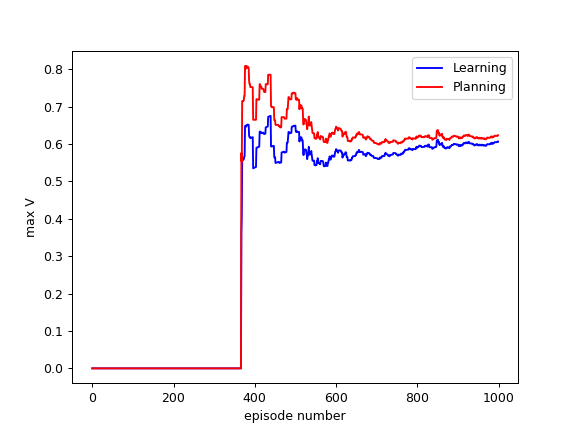

In [28]:
fig = plt.figure()
ax = plt.axes()
ax.plot(strategy.monitor["Vs"], "b")
ax.plot(strategy.monitor["check"], "r")
ax.set_xlabel("episode number")
ax.set_ylabel("max V")
ax.legend(["Learning", "Planning"])
fig.show()
fig.canvas.draw()

## Conclusion 

In this notebook, the hyperparameters used by the reinforcement learning methods Q-Learning, Monte Carlo, N-Step Q-Learning, and Value Iteration were discussed, and their impact on the convergence and accuracy of the calculated results was demonstrated. Although some interesting numerical experiments were presented, the only objective was to show how this impact can be studied, not to draw general conclusions.